### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = '1'


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import pickle
import shap

### Helper Functions

In [2]:
def load_data(dataset, classifier):
    df_encoded = pd.read_csv(f'../Data & Outputs/{dataset}/df_encoded.csv')
    with open(f'../Data & Outputs/{dataset}/{classifier}/' \
          f'{dataset}_{classifier}_mul_selected_features.pkl', 'rb') as f:
         seq_fea_sel_features, rfe_cv_features = pickle.load(f)
    return df_encoded, seq_fea_sel_features


def create_cluster_data(df_encoded, features):
    X = df_encoded[df_encoded['churn'] == 1].copy()
    # Select the relevant features for clustering
    X = X[features]
    return X

def plot_silhouette_scores(cluster_range, silhouette_scores, model):
    plt.figure(figsize=(12, 8))
    plt.plot(cluster_range, silhouette_scores, 'o-', linewidth=2)
    if isinstance(model, GaussianMixture):
        plt.xlabel('Number of Components', fontsize=16)
    elif isinstance(model, KMeans):
        plt.xlabel('Number of Clusters', fontsize=16)
    else:
        plt.xlabel('Epsilon', fontsize=16)
    plt.ylabel('Silhouette Score', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{model.__class__.__name__}', fontsize=18, fontweight='bold')
    
    plt.show()
    
def plot_silhouette_analysis(model_instance, X, n_clusters):
    cluster_labels = model_instance.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.suptitle(f"Silhouette analysis for {model_instance.__class__.__name__} (n_clusters={n_clusters})", fontsize=14, fontweight='bold')

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    plt.show()
    
def find_optimal_clusters(model, X, cluster_range, plot_analysis=False):
    silhouette_scores = []
    for n_clusters in cluster_range:
        if isinstance(model, GaussianMixture):
            model_instance = model.set_params(n_components=n_clusters)
        elif isinstance(model, KMeans):
            model_instance = model.set_params(n_clusters=n_clusters)
        elif isinstance(model, DBSCAN):
            model_instance = model.set_params(eps=n_clusters)
        else:
            raise ValueError("Invalid model type")
        
        cluster_labels = model_instance.fit_predict(X)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if num_clusters > 1:
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            if plot_analysis:
                plot_silhouette_analysis(model_instance, X, num_clusters)
        else:
            silhouette_scores.append(-1)
    
    return silhouette_scores
    

In [3]:
dataset = input("Enter dataset name: ")
classifier = input("Enter classifier name: ")
print("Dataset: ", dataset)
print("Classifier: ", classifier)

Dataset:  Orange
Classifier:  RF


In [4]:
df_encoded, features = load_data(dataset, classifier)
X = create_cluster_data(df_encoded, features)

In [5]:
# Normalize data
scaler = StandardScaler().set_output(transform='pandas')
X_normalized = scaler.fit_transform(X)
X_normalized

,international plan,voice mail plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total intl calls,total intl charge,customer service calls
10,-0.629249,-0.445546,-0.431803,-1.128946,-1.128726,0.311364,0.310785,0.075786,0.720474,0.717383,0.956157
15,-0.629249,-0.445546,-0.431803,1.827835,1.827520,2.039462,2.038845,-0.947916,1.897437,-1.897531,0.956157
21,-0.629249,-0.445546,-0.431803,-2.096646,-2.096505,-0.822639,-0.823041,0.092777,0.720474,-1.791341,1.496302
33,-0.629249,-0.445546,-0.431803,0.619298,0.619078,0.773867,0.772967,1.592225,-0.456490,0.398815,-0.664277
41,1.589197,2.244438,3.028739,-0.490583,-0.490368,-0.164685,-0.165058,-1.763479,4.251363,1.394340,-1.204422
...,...,...,...,...,...,...,...,...,...,...,...
3301,-0.629249,-0.445546,-0.431803,1.060348,1.060296,-0.197583,-0.196933,-1.028623,-0.064168,-0.105585,-1.204422
3304,1.589197,-0.445546,-0.431803,-0.301976,-0.301763,-0.267248,-0.267512,0.026937,0.328153,1.115593,0.956157
3320,1.589197,-0.445546,-0.431803,-0.970806,-0.970844,-0.309822,-0.310771,-1.808081,-0.064168,-0.357785,0.956157
3322,-0.629249,-0.445546,-0.431803,1.656637,1.656836,1.027373,1.027964,-0.525267,-0.848811,0.292625,0.956157


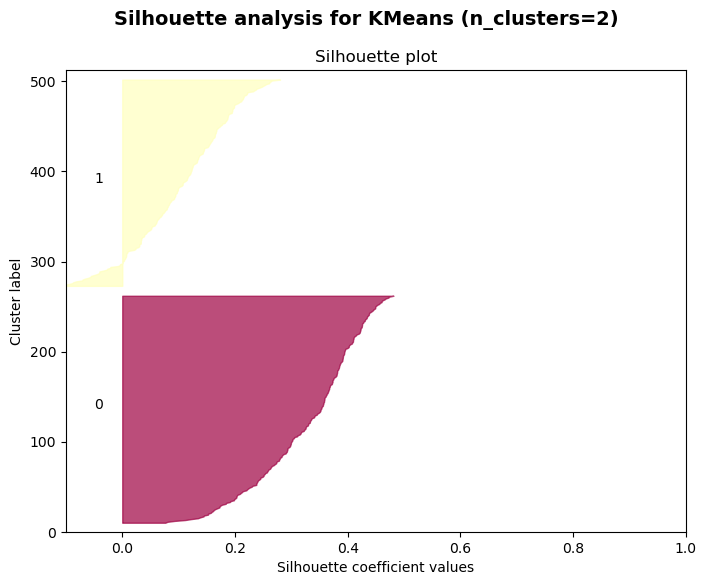

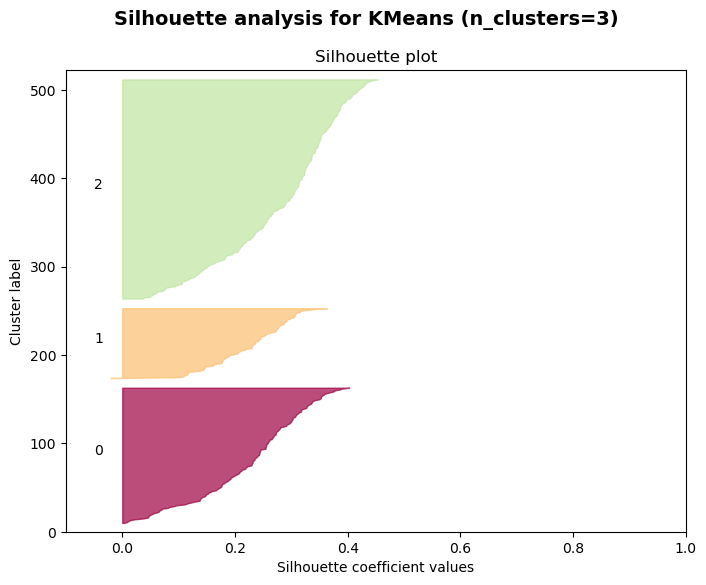

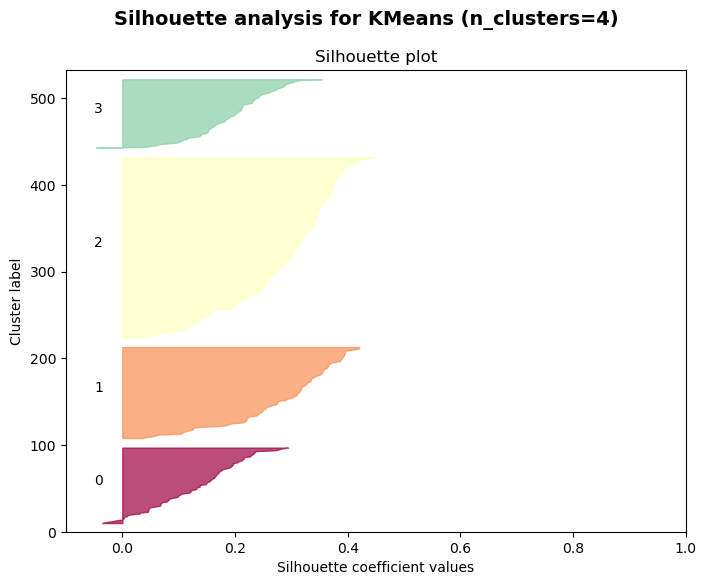

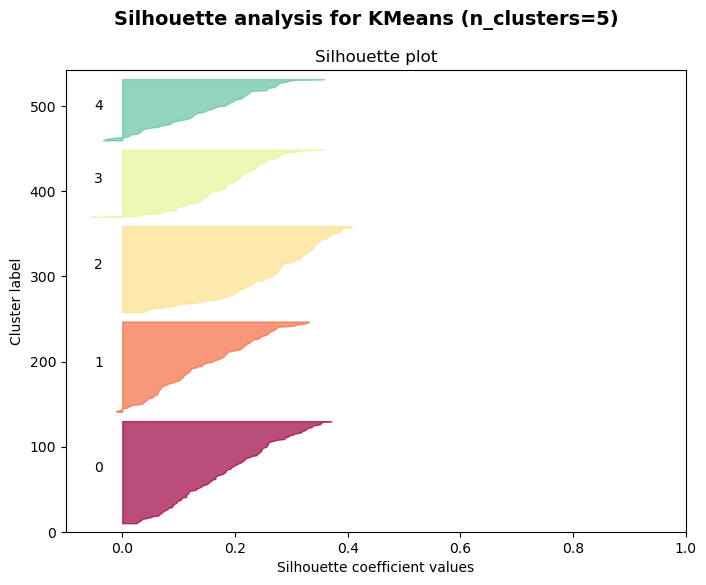

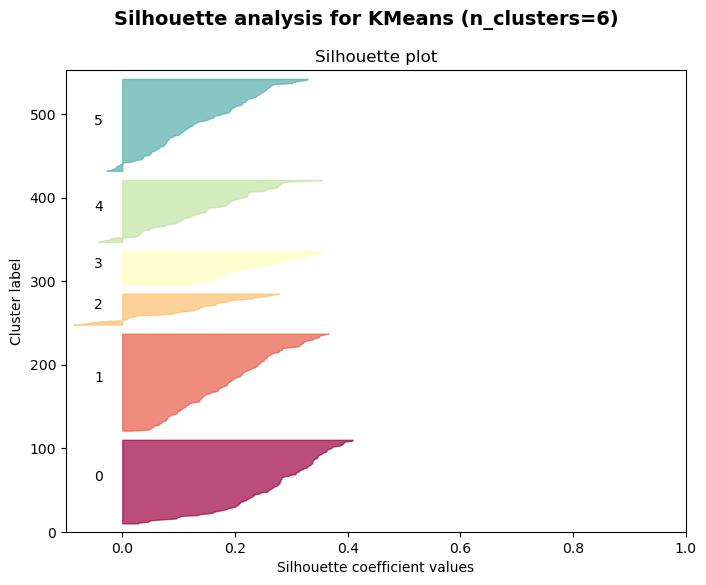

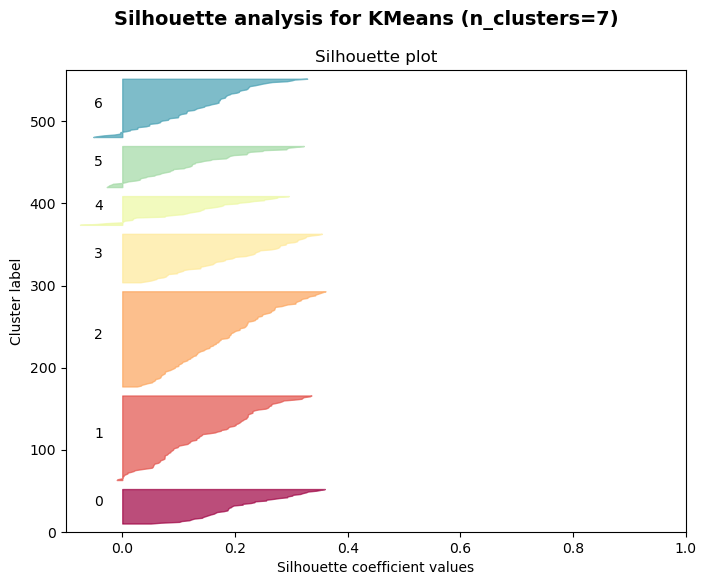

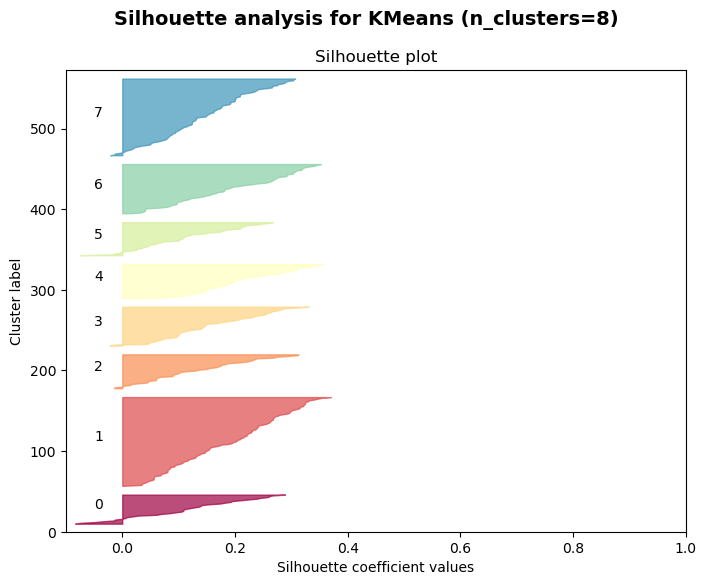

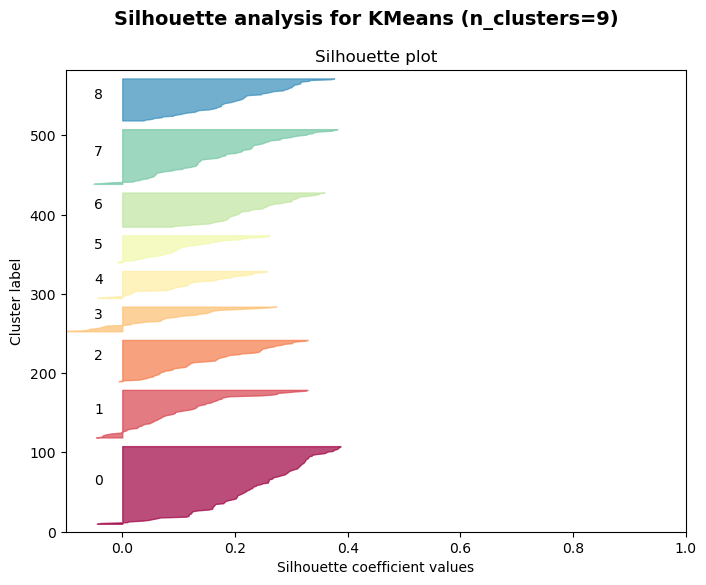

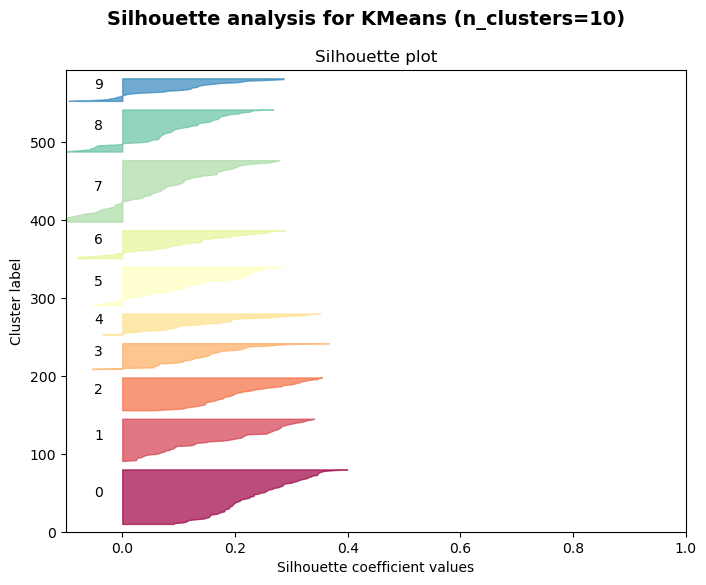

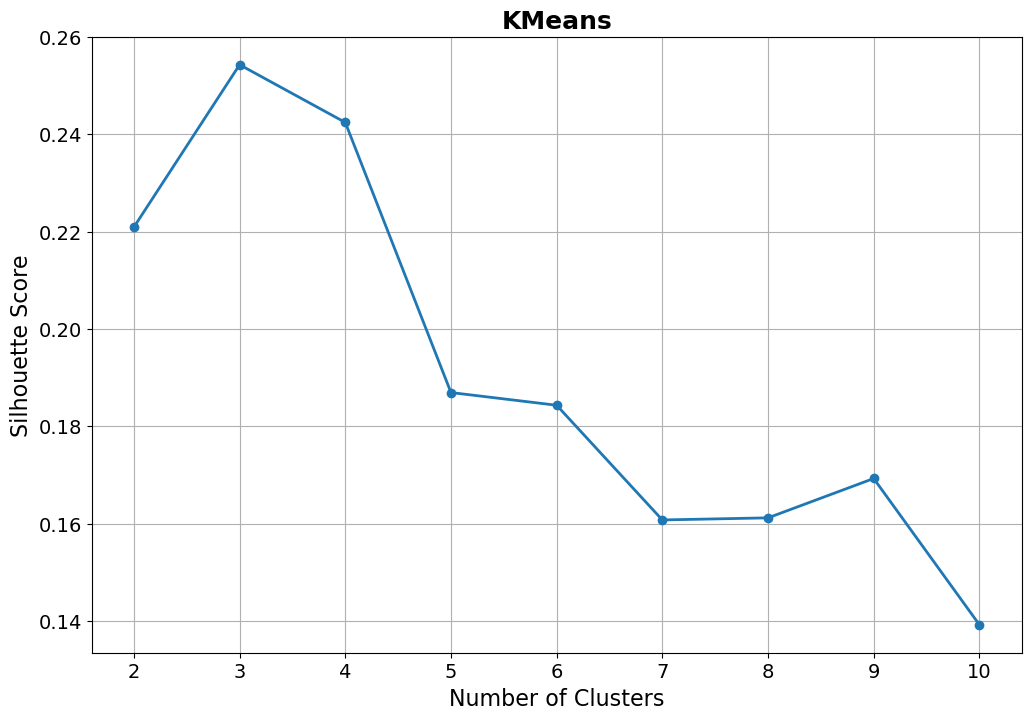

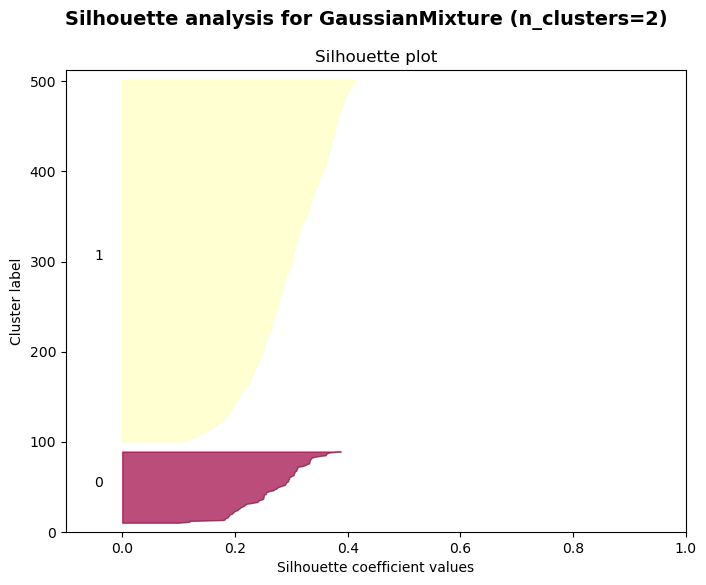

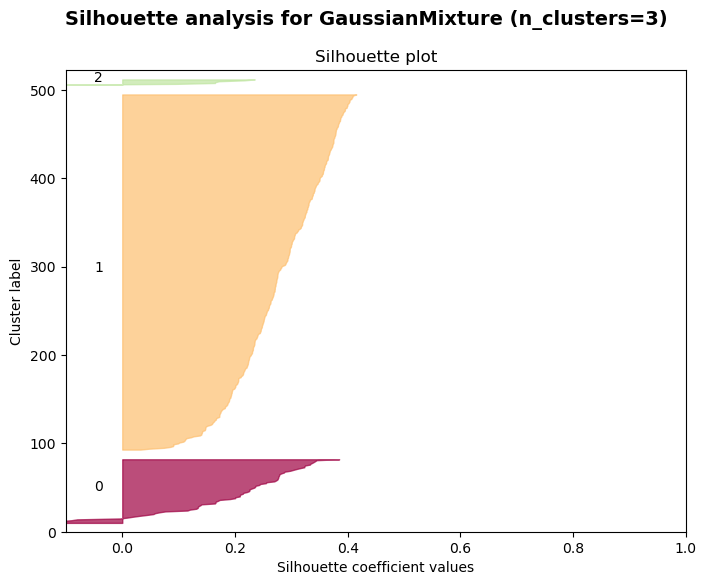

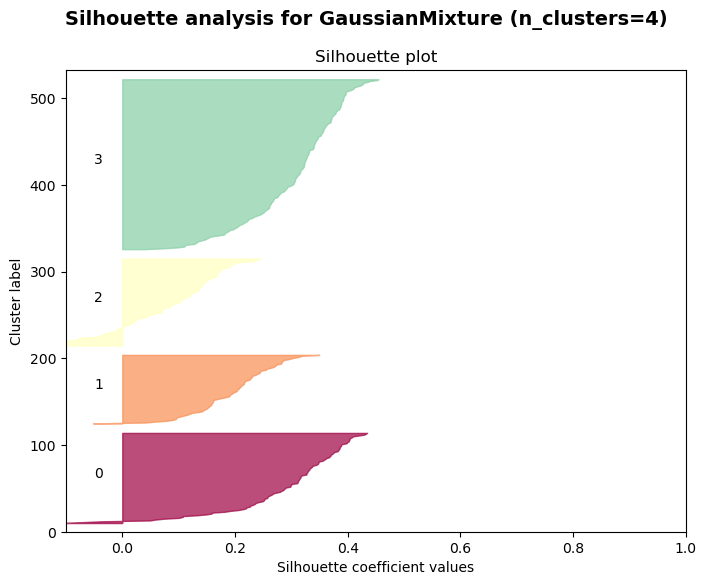

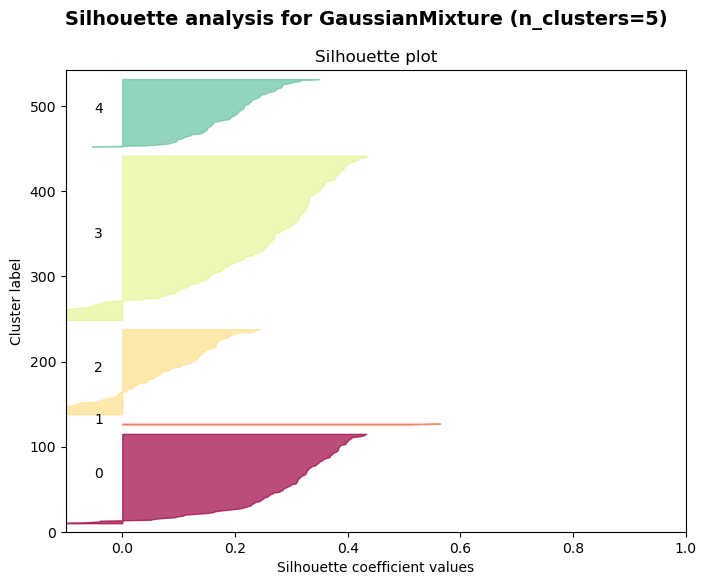

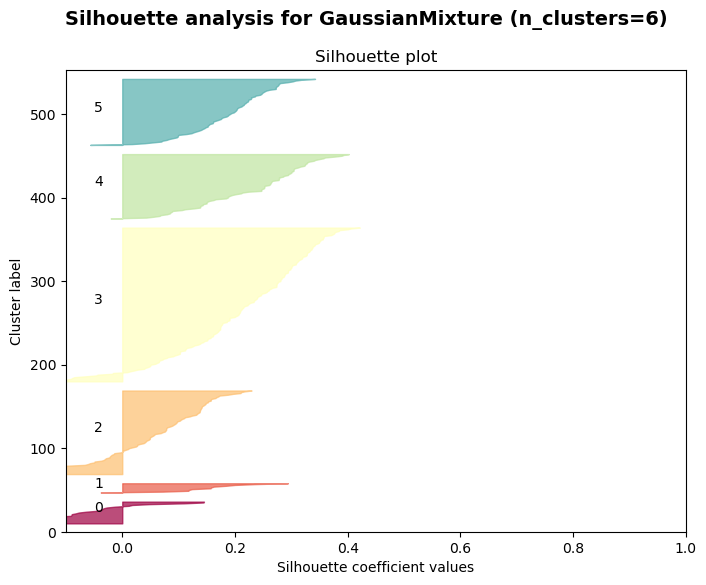

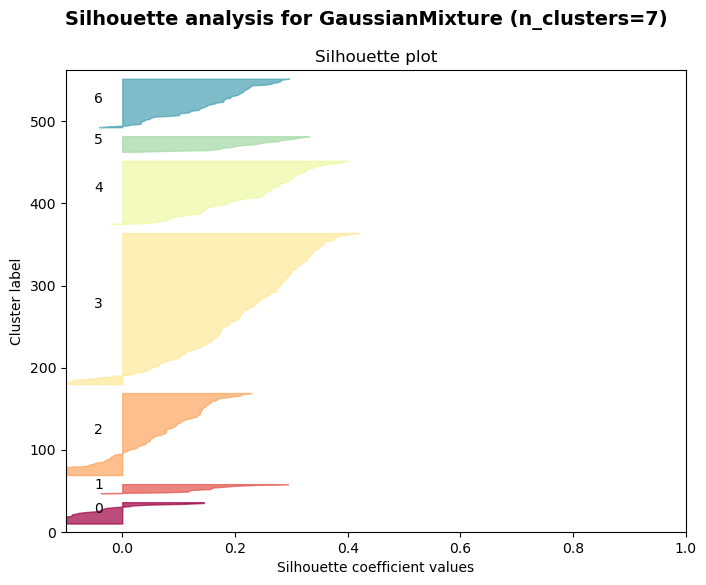

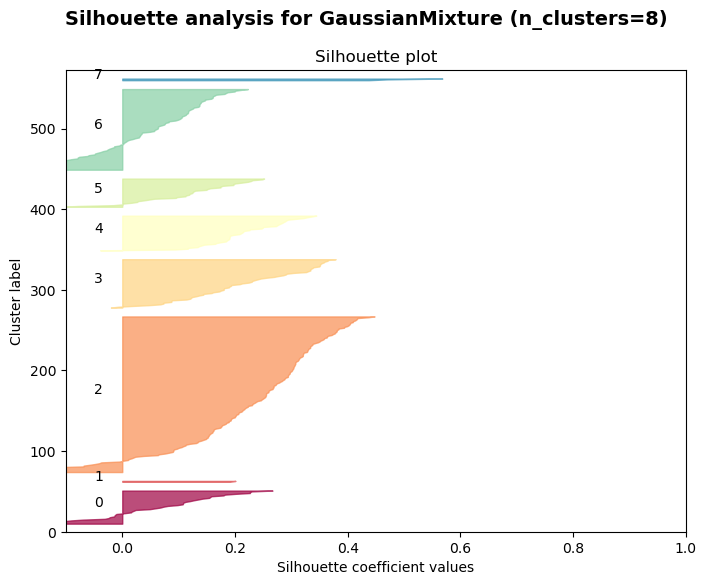

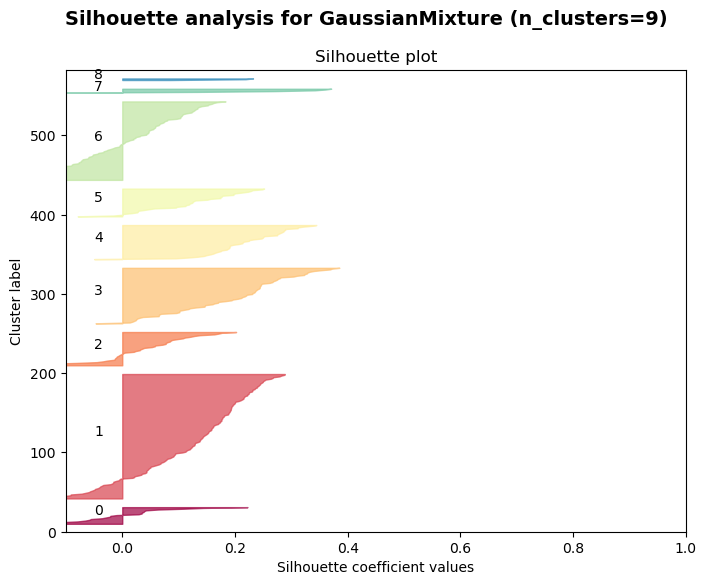

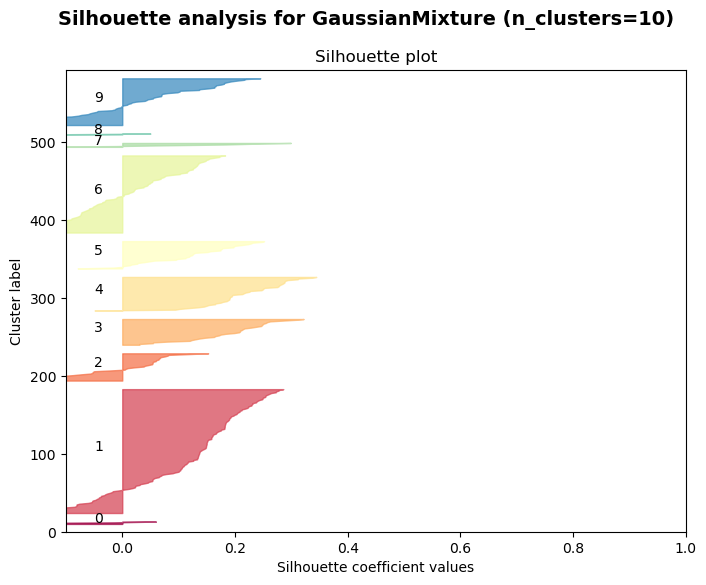

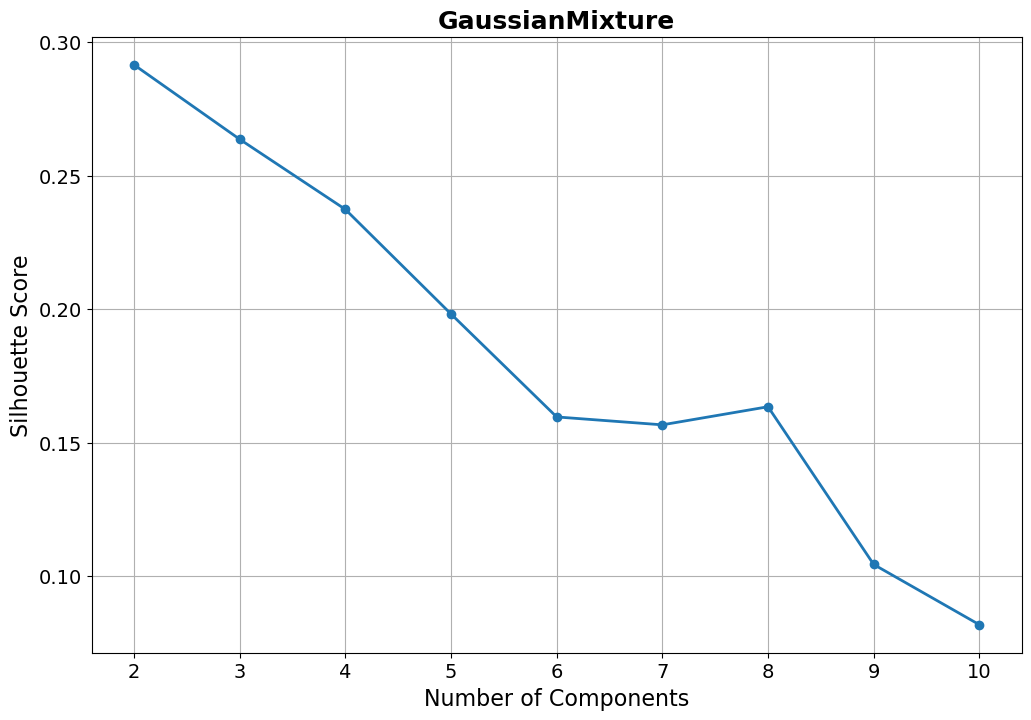

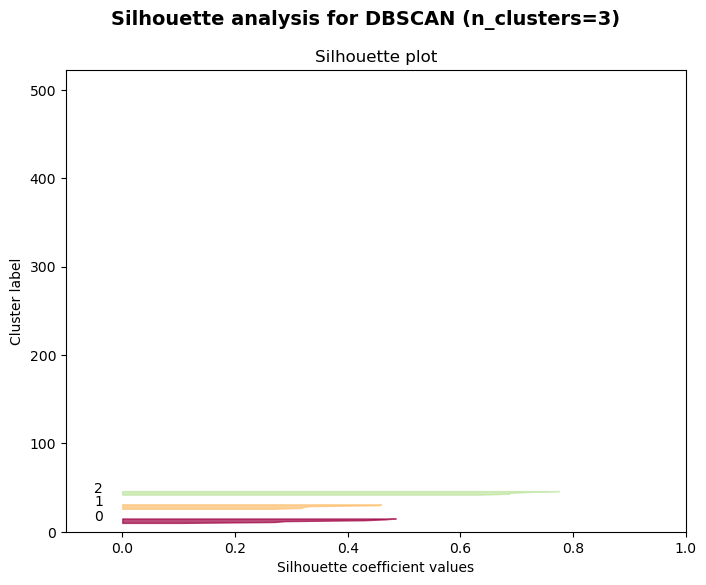

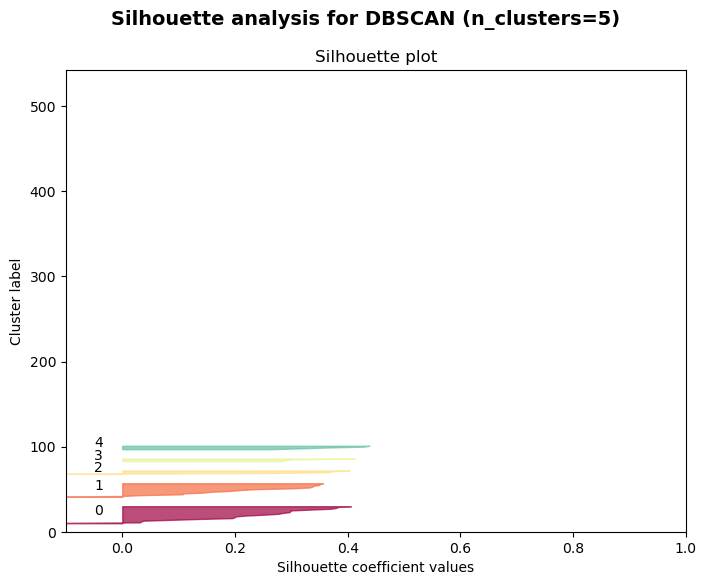

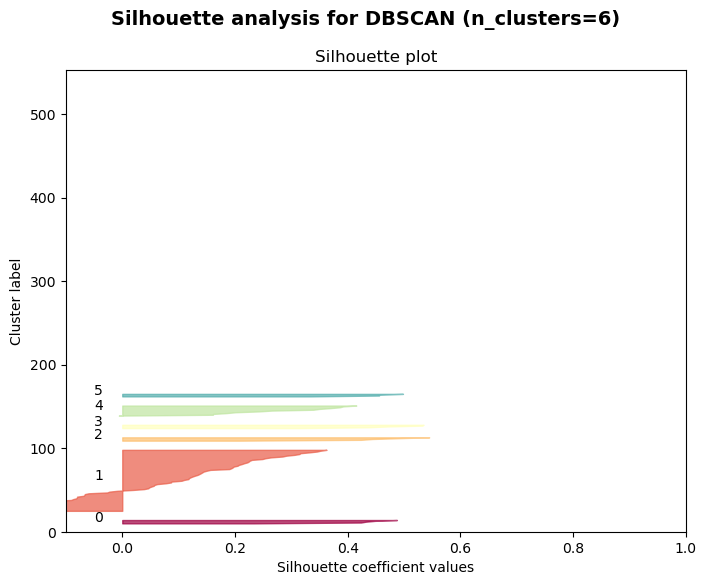

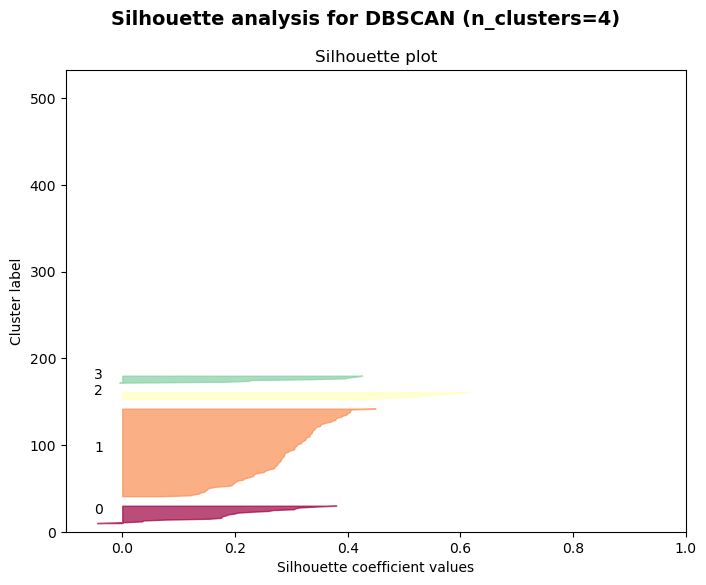

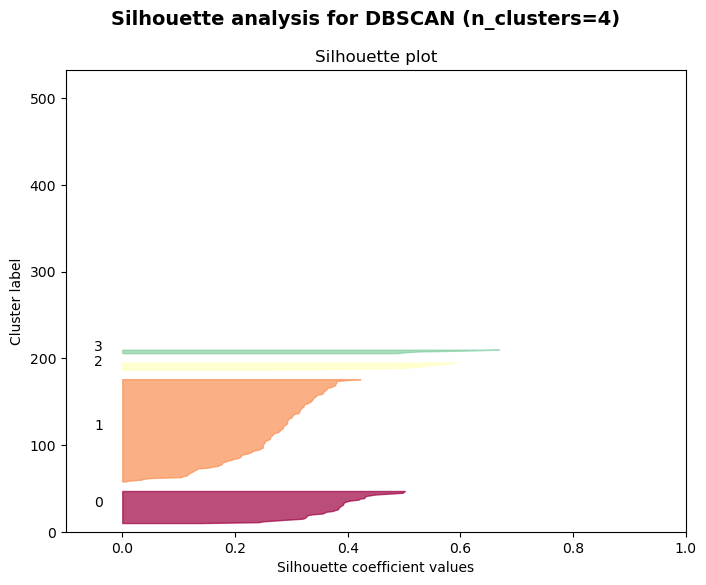

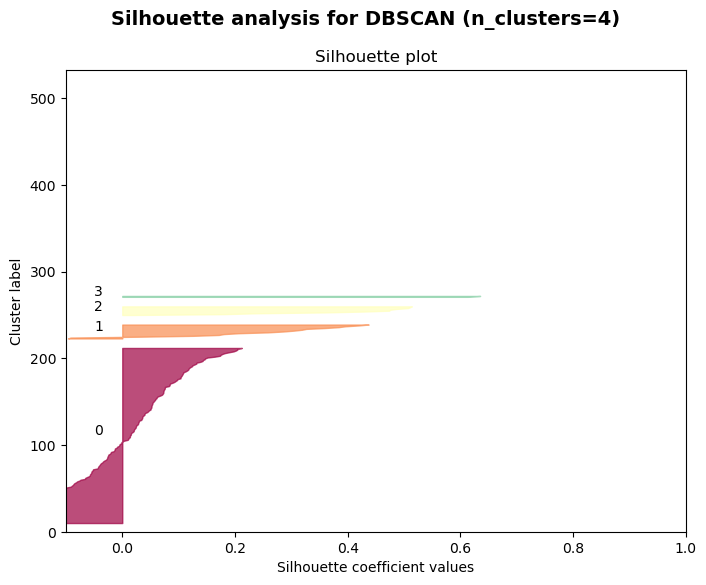

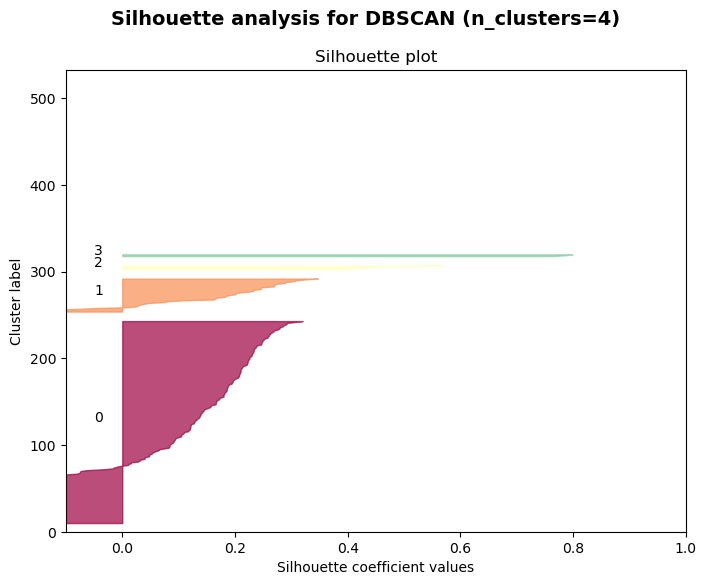

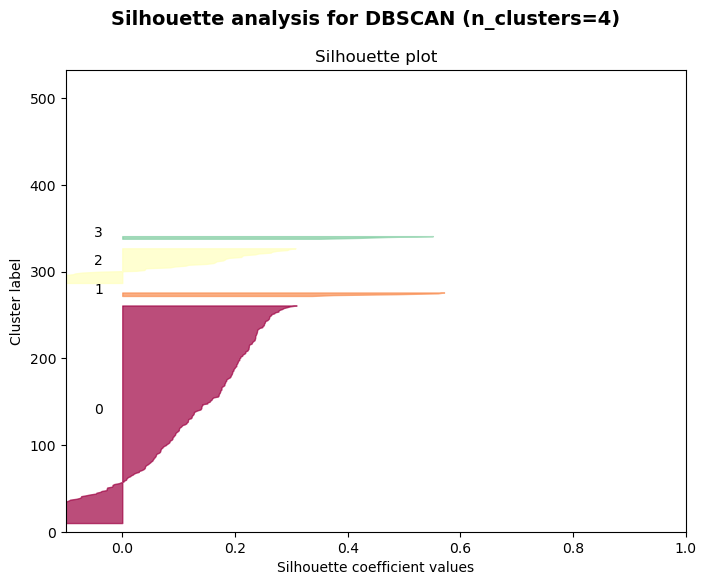

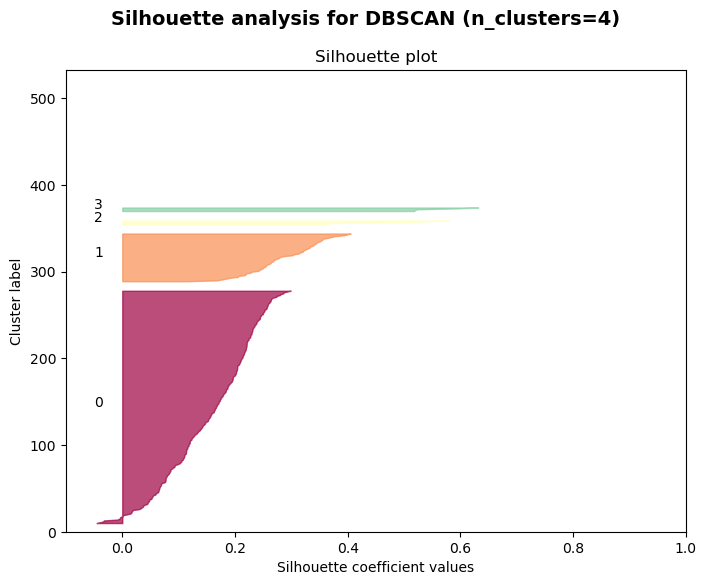

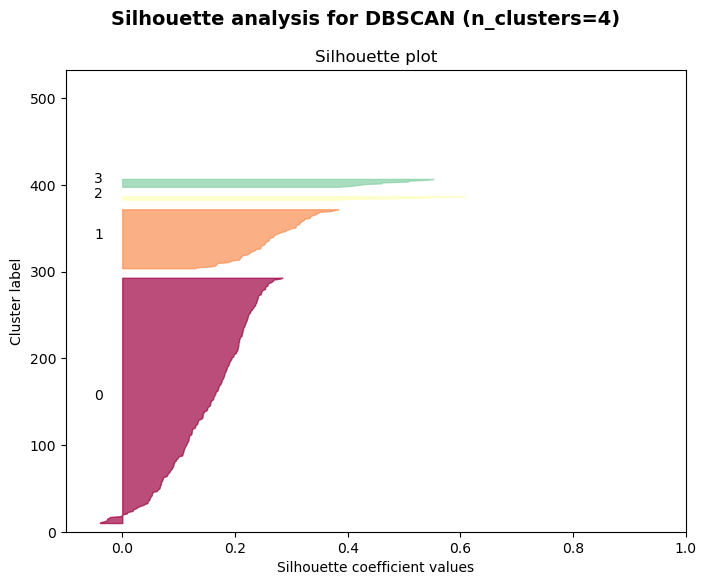

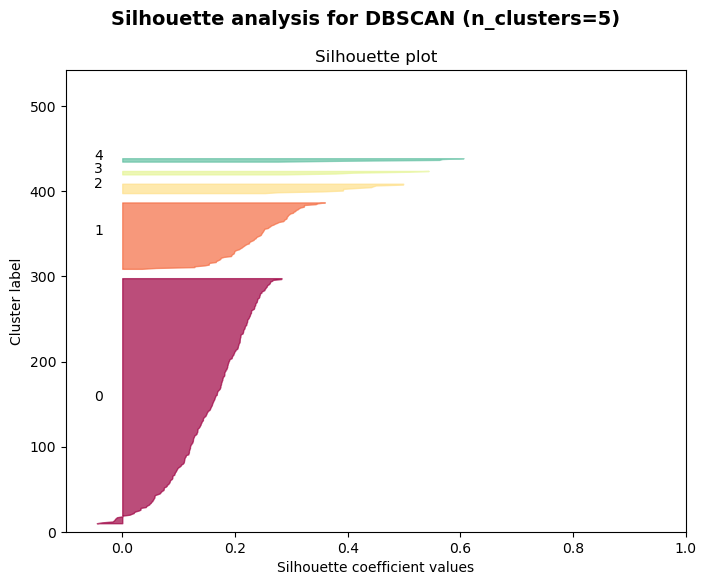

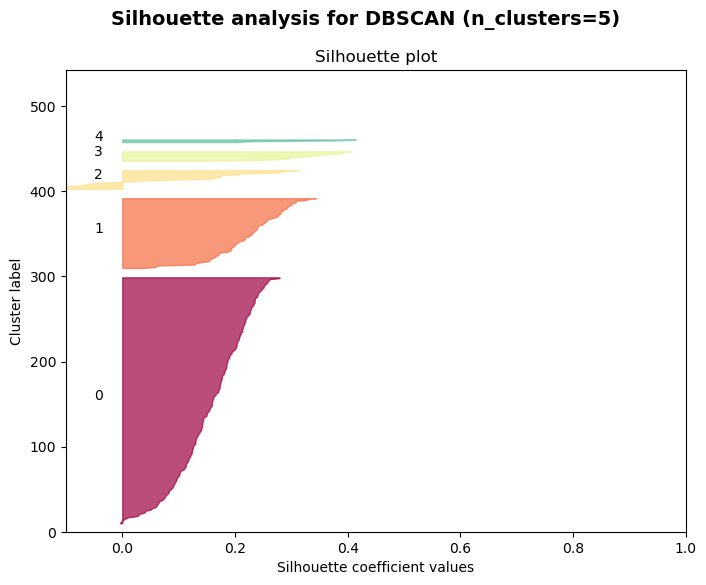

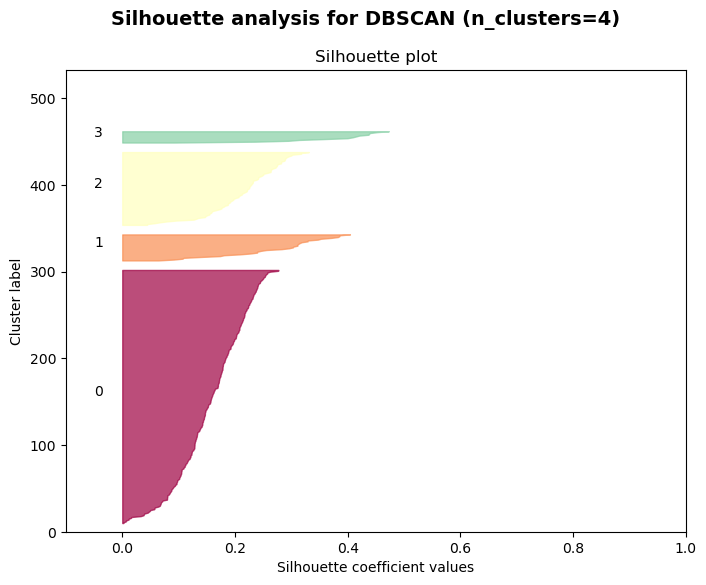

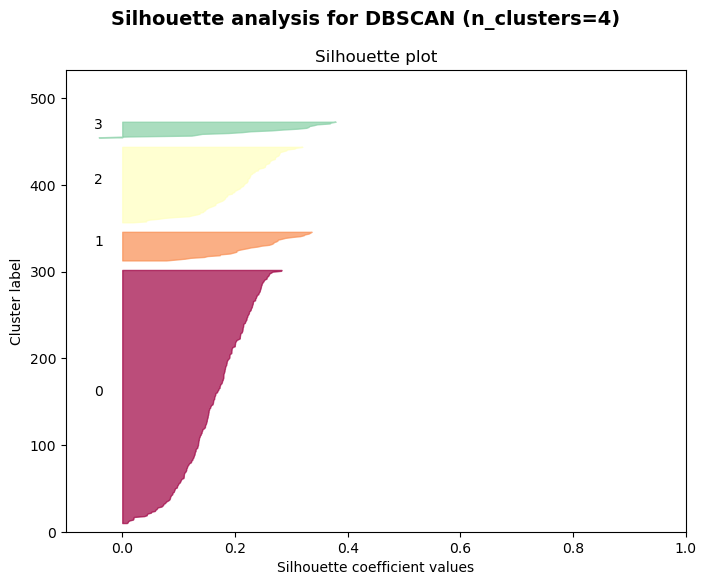

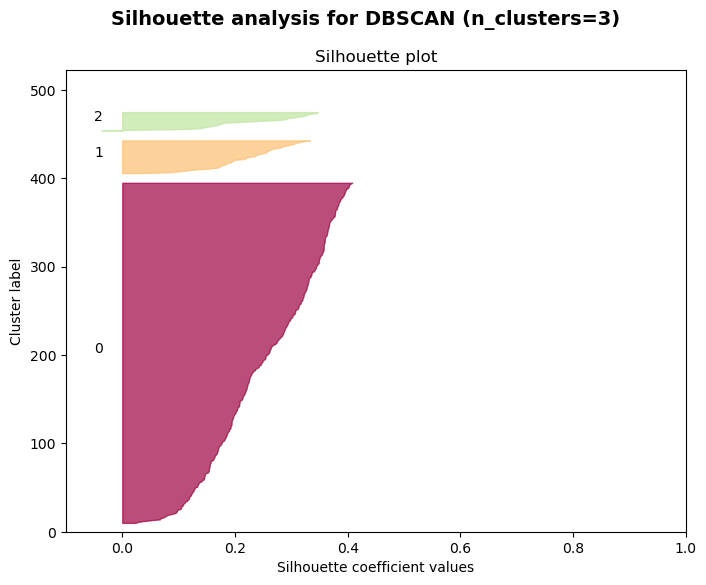

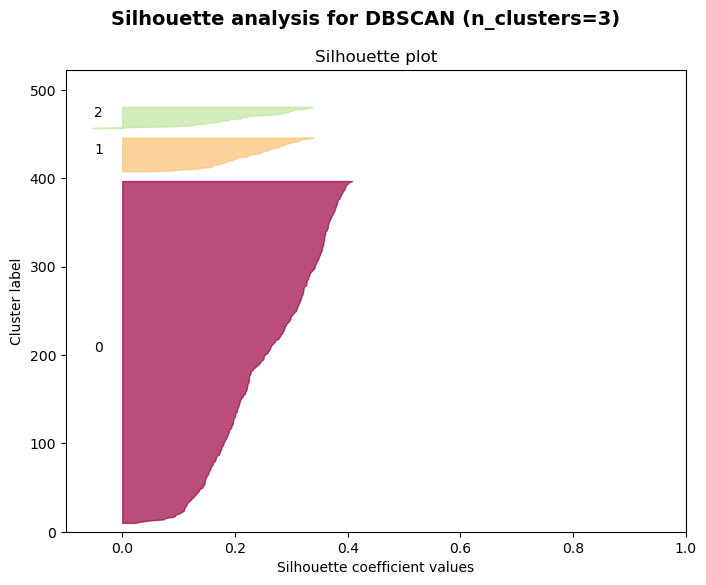

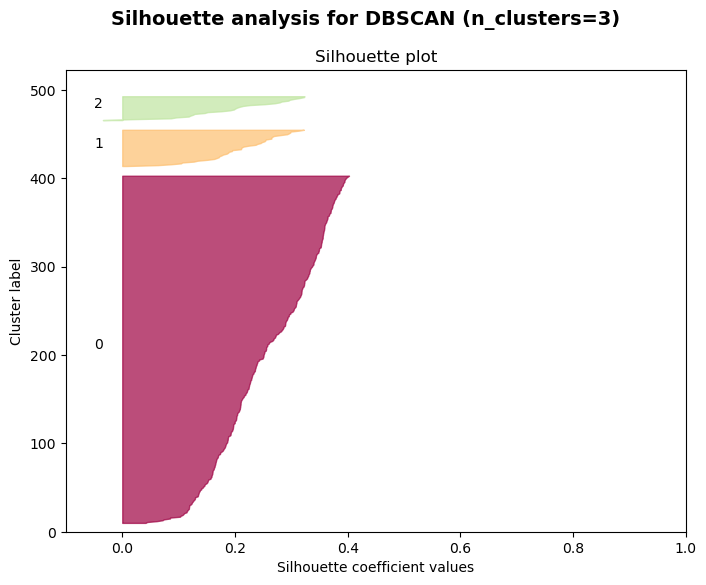

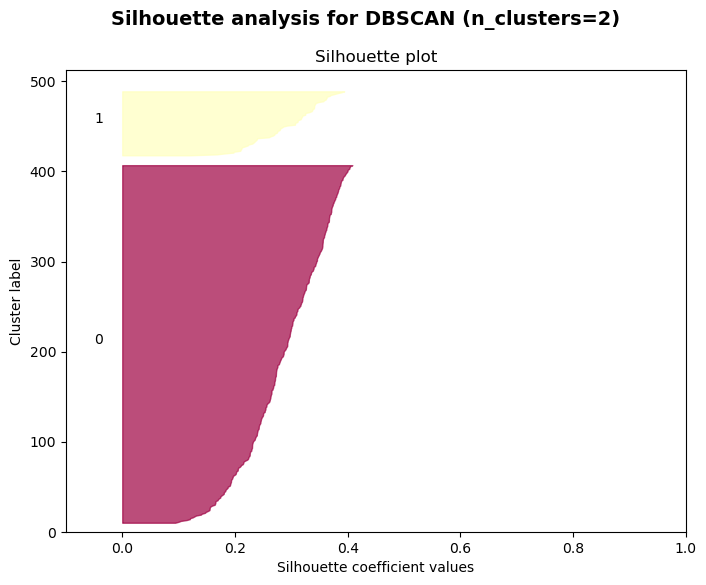

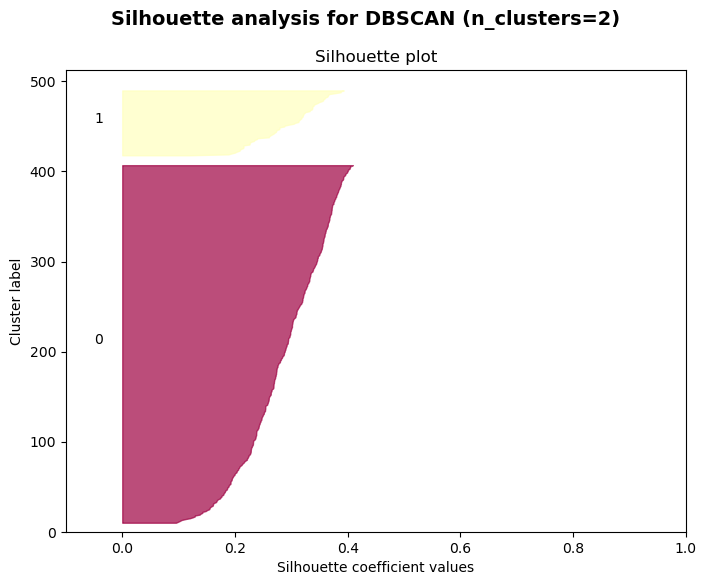

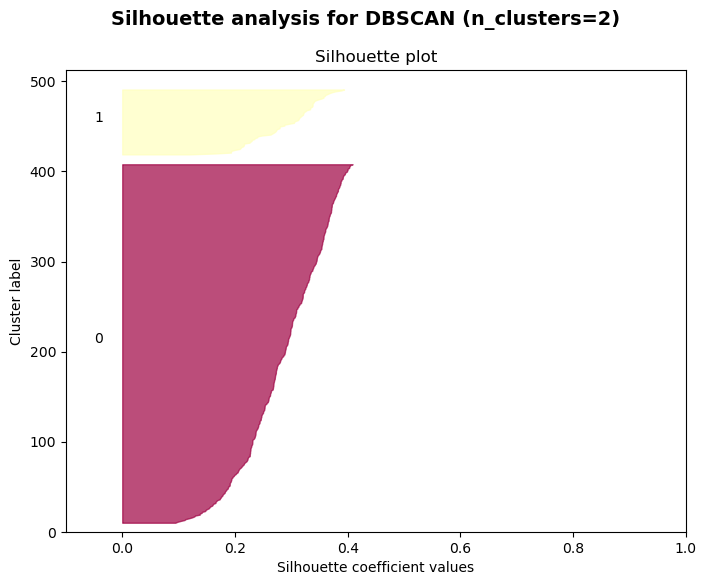

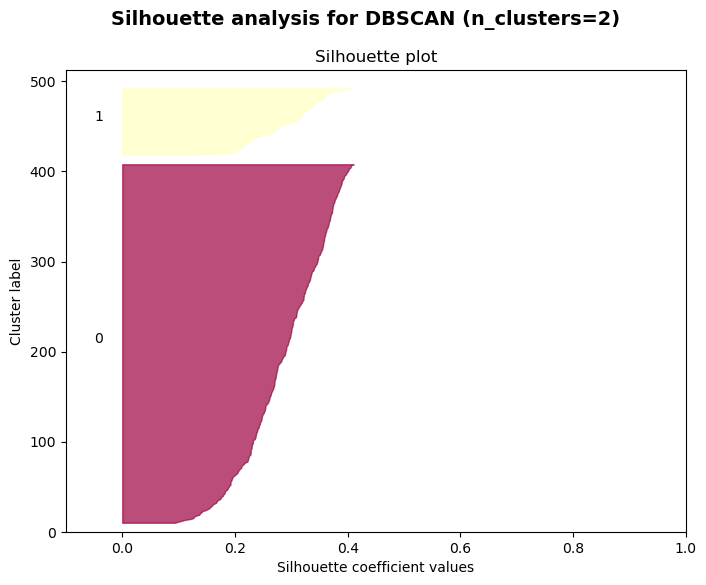

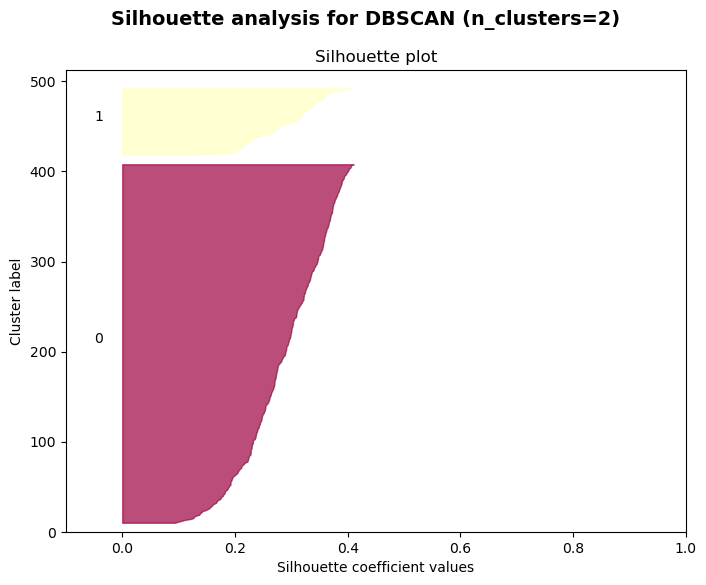

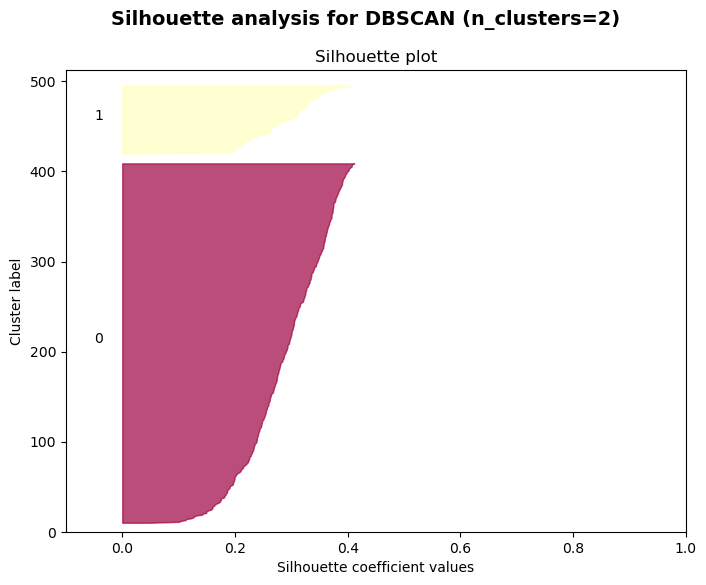

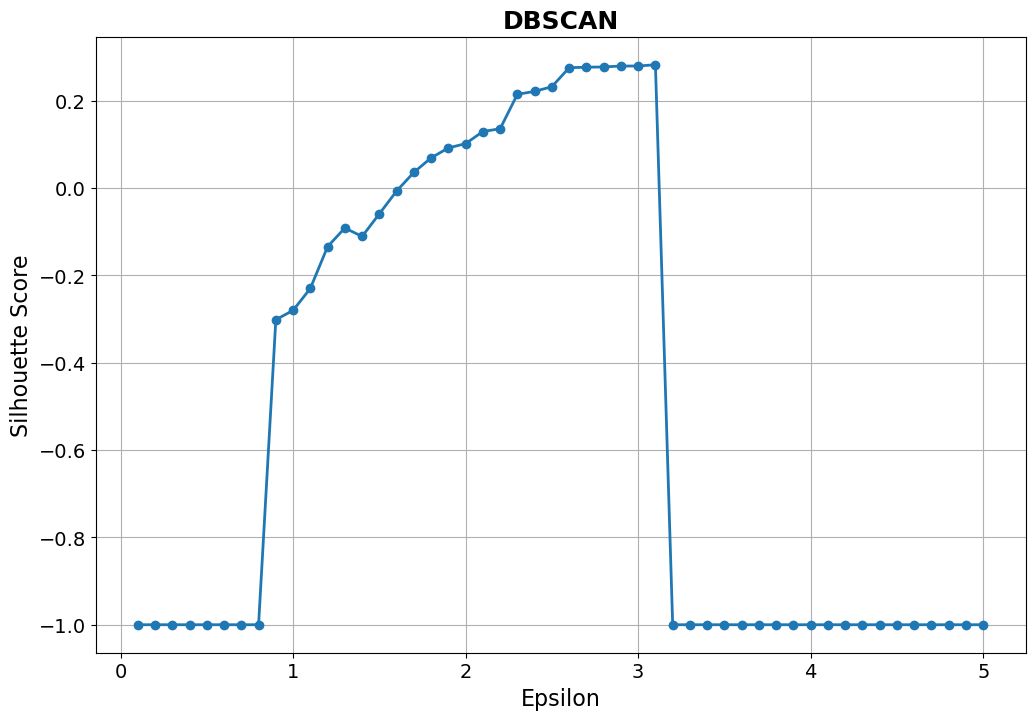

In [6]:
# Find optimal clusters for KMeans
cluster_range = range(2, 11)
model = KMeans(random_state=42, n_init=10)
silhouette_scores = find_optimal_clusters(model, X_normalized, cluster_range, plot_analysis=True)
plot_silhouette_scores(cluster_range, silhouette_scores, model)

# Find optimal clusters for GaussianMixture
model = GaussianMixture(random_state=42)
silhouette_scores = find_optimal_clusters(model, X_normalized, cluster_range, plot_analysis=True)
plot_silhouette_scores(cluster_range, silhouette_scores, model)

# Find optimal eps value for DBSCAN
eps_values = np.arange(0.1, 5.1, 0.1)
model = DBSCAN(min_samples=5)
silhouette_scores = find_optimal_clusters(model, X_normalized, eps_values, plot_analysis=True)
plot_silhouette_scores(eps_values, silhouette_scores, model)


### SHAP for Clustered Data

In [7]:
def create_cluster_group(df: pd.DataFrame, n_clusters: int, target: str):
    """
    Function to perform k-means clustering on churned customers
    """
    features = df
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_scaled)
     # get the cluster assignments for each data point
    clusters = kmeans.labels_
    # add cluster assignments to the original dataframe
    df['Cluster'] = clusters
    return df

In [8]:
n_clusters = 4
df_clustered = create_cluster_group(X, n_clusters, 'Cluster')
class_names = df_clustered['Cluster'].unique()

In [9]:
X = df_clustered.drop('Cluster', axis=1)
y = df_clustered['Cluster']

# train a model
model = RandomForestClassifier(random_state=0)
model.fit(X, y)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Cluster 0
-------------------


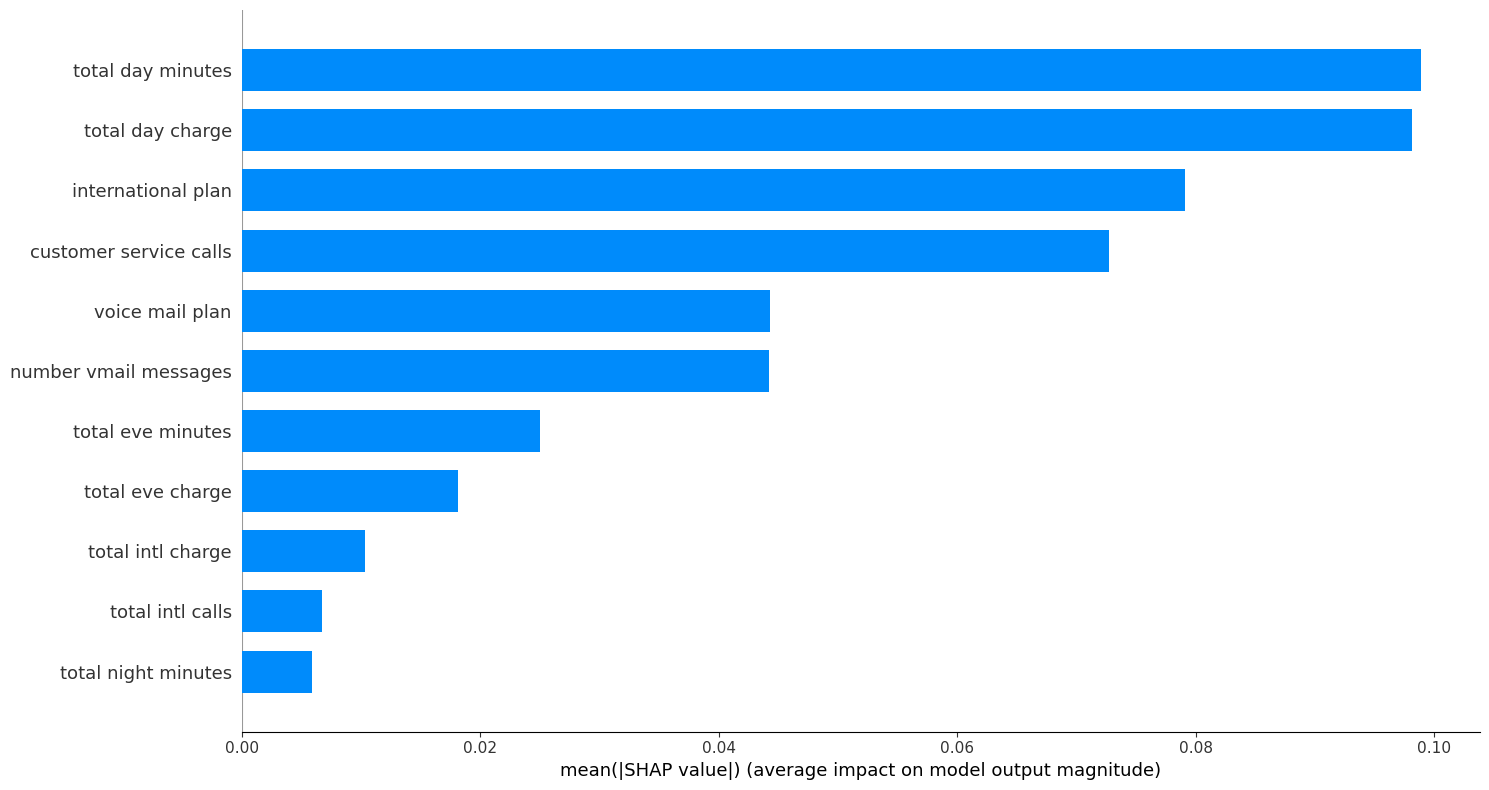

Cluster 1
-------------------


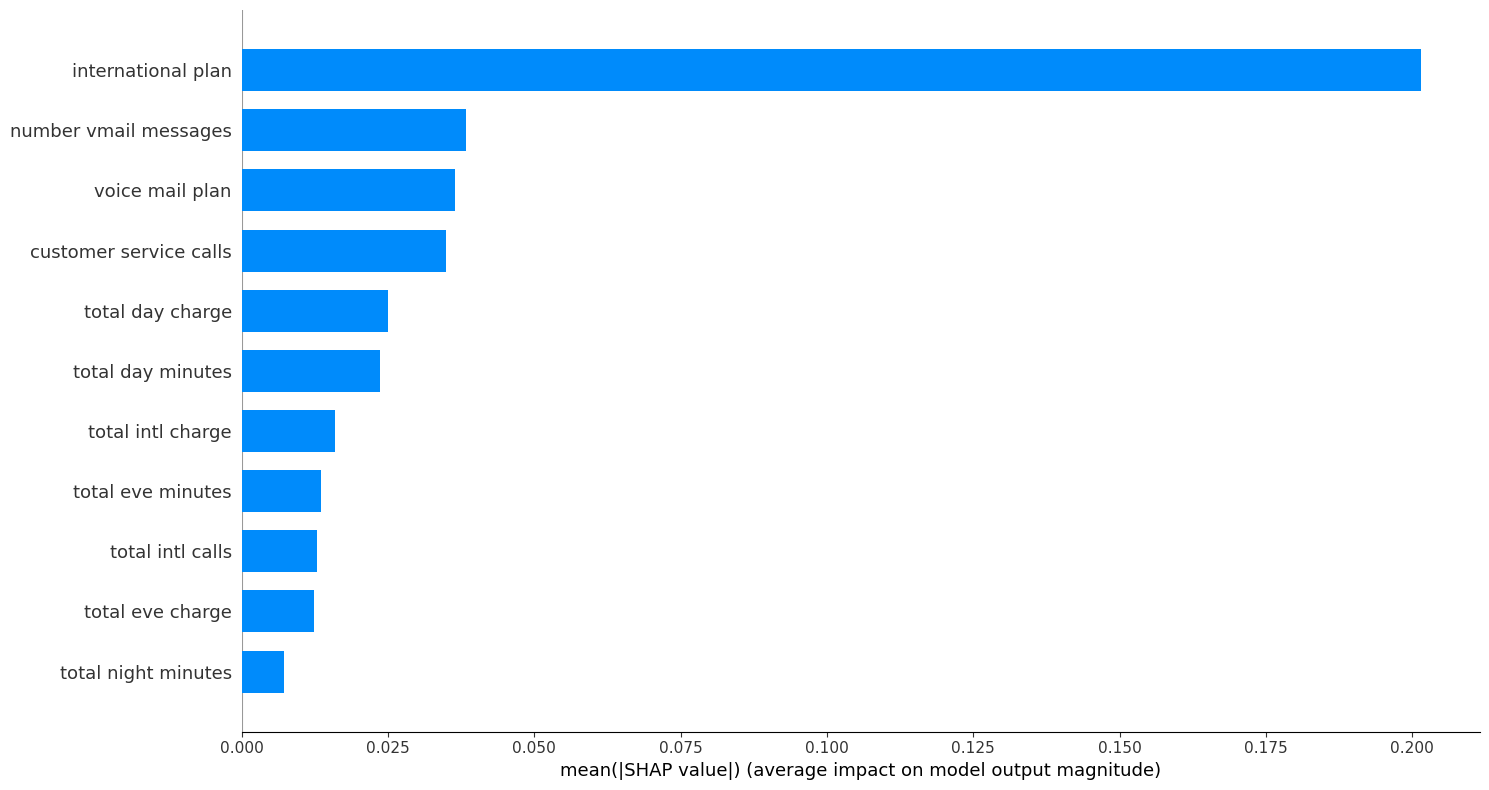

Cluster 2
-------------------


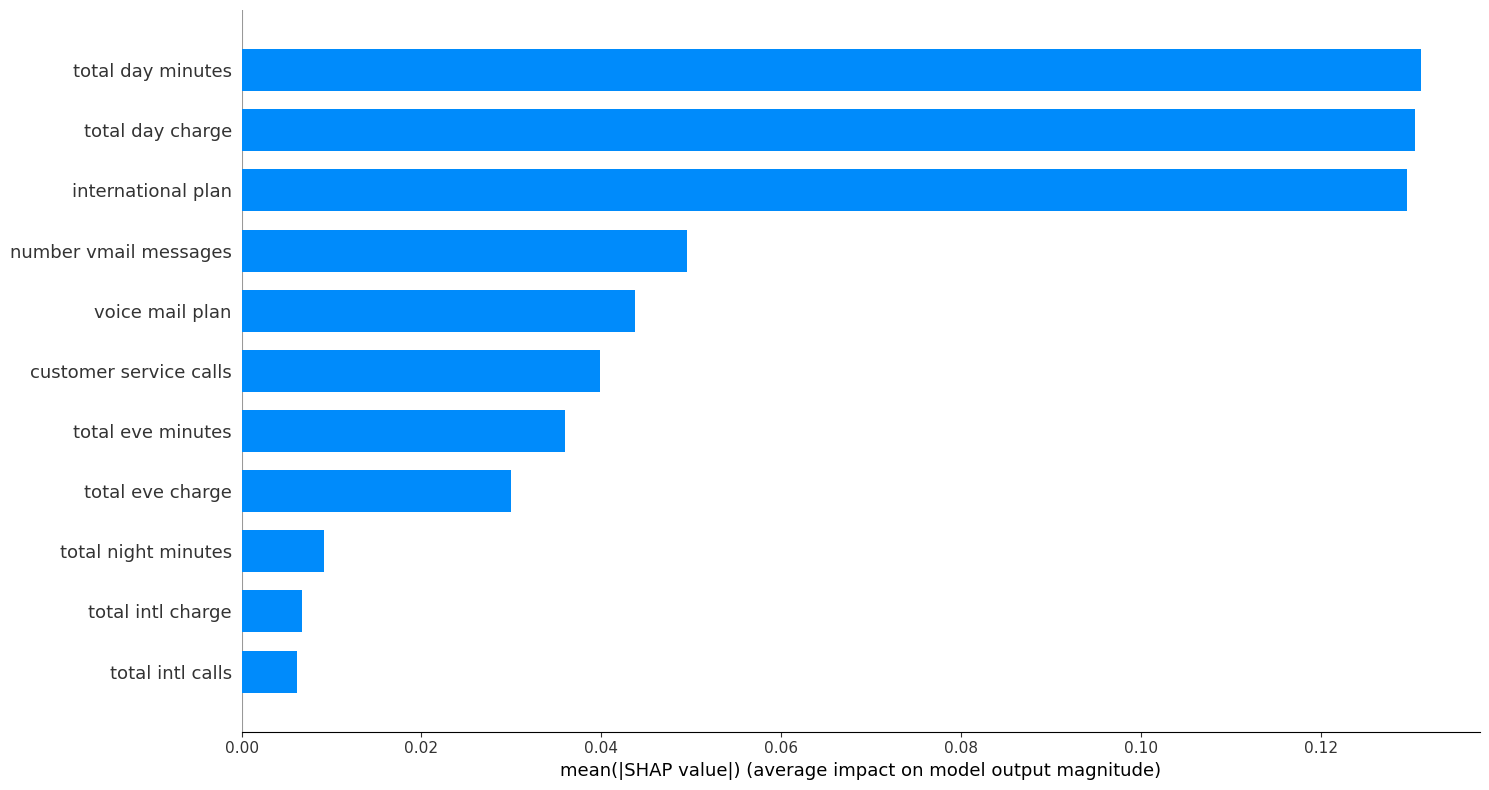

Cluster 3
-------------------


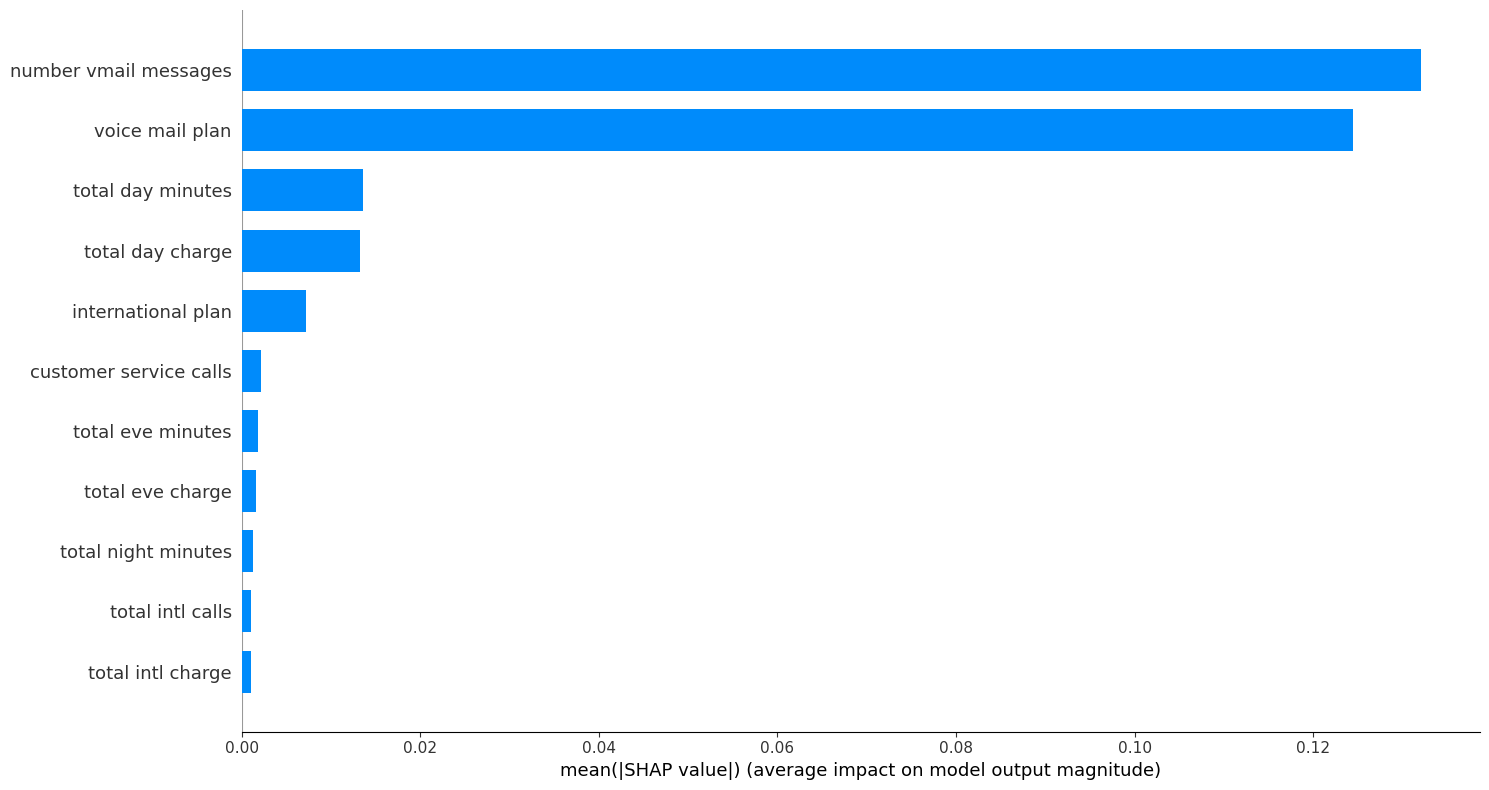

In [10]:
for i in range(n_clusters):
    print(f'Cluster {i}')
    print(f'-------------------')
    shap.summary_plot(shap_values[:,:,i], X, plot_type='bar', plot_size=(15, 8))

### Percentage of Each Churned Group 

In [11]:
# Get user input for the clustering algorithm
algorithm = input("Enter clustering algorithm (KM/GM/DB): ")

Clustering algorithm:  KM
cluster
4    211
3    105
2     87
1     80
Name: count, dtype: int64


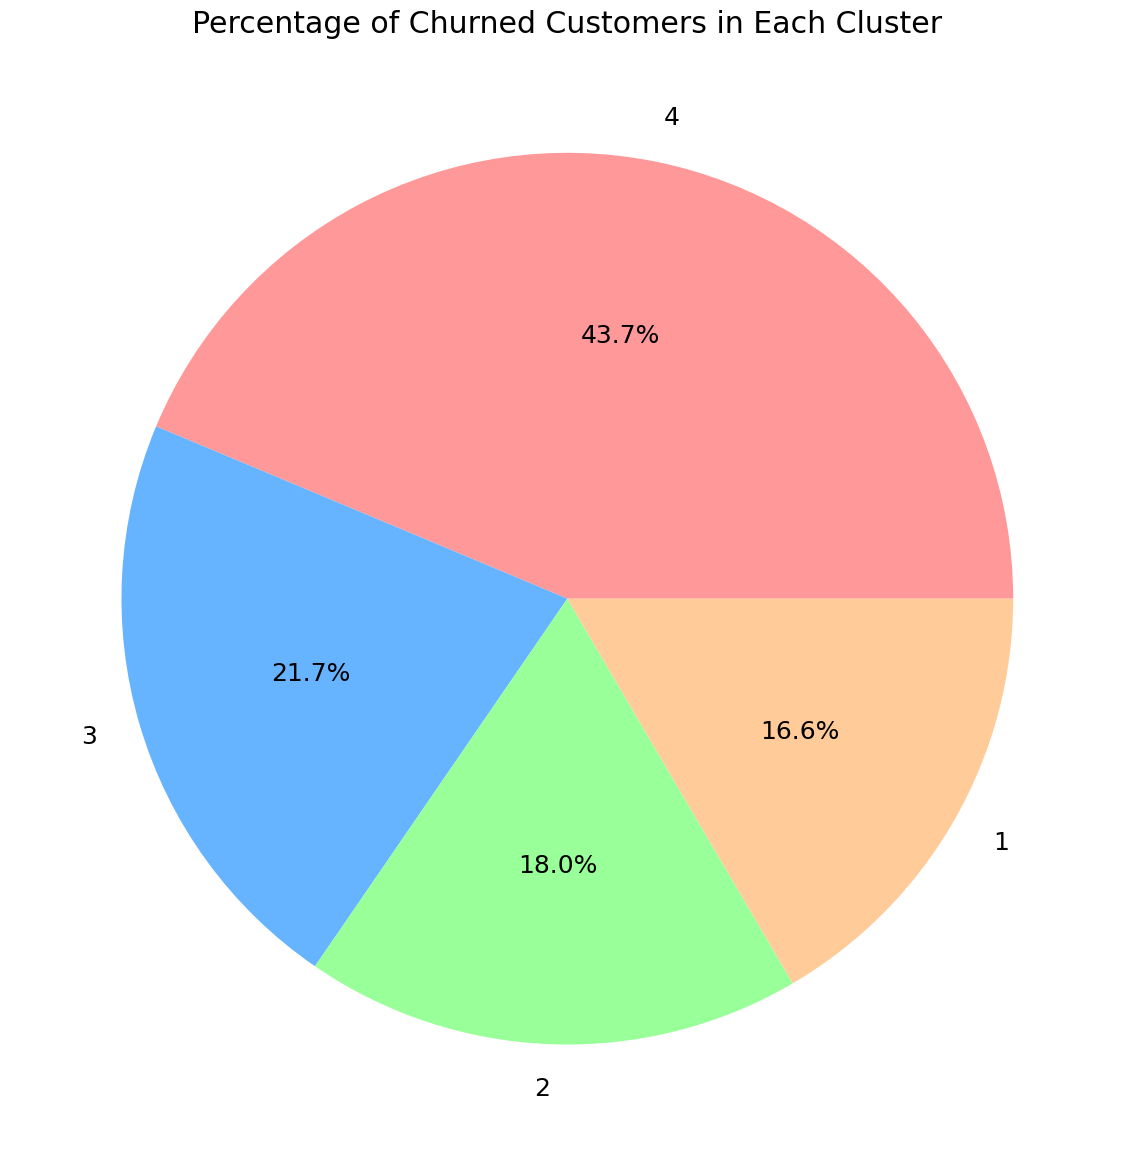

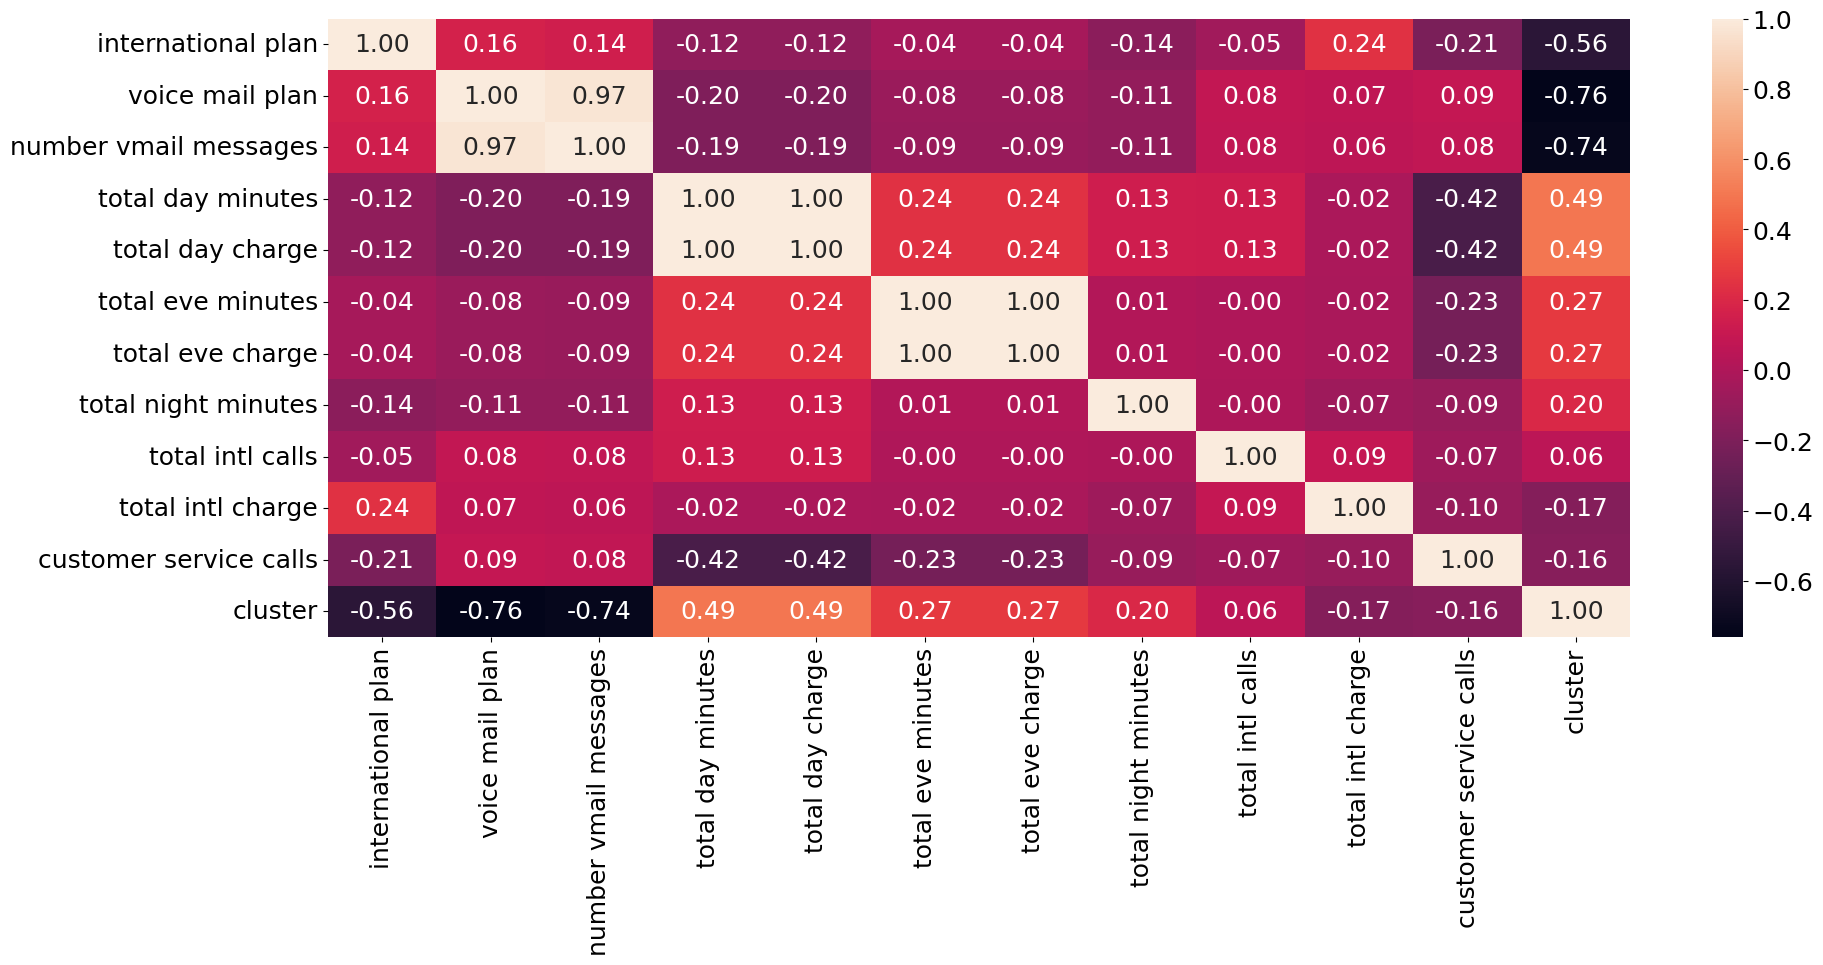

In [12]:
print("Clustering algorithm: ", algorithm)

if classifier == 'BRF':
    if algorithm == 'KM':
        model = KMeans(n_clusters=2, random_state=42)
    elif algorithm == 'GM':
        model = GaussianMixture(n_components=2, random_state=42)
    elif algorithm == 'DB':
        model = DBSCAN(eps=3.5, min_samples=5)
    else:
        print("Invalid algorithm choice. Please enter either 'KM', 'GM', or 'DB'.")


elif classifier == 'XGB':
    if algorithm == 'KM':
        model = KMeans(n_clusters=4, random_state=42)
    elif algorithm == 'GM':
        model = GaussianMixture(n_components=2, random_state=42)
    elif algorithm == 'DB':
        model = DBSCAN(eps=3.5, min_samples=5)
    else:
        print("Invalid algorithm choice. Please enter either 'KM', 'GM', or 'DB'.")

else:
    if algorithm == 'KM':
        model = KMeans(n_clusters=4, random_state=42)
    elif algorithm == 'GM':
        model = GaussianMixture(n_components=2, random_state=42)
    elif algorithm == 'DB':
        model = DBSCAN(eps=3.5, min_samples=5)
    else:
        print("Invalid algorithm choice. Please enter either 'KM', 'GM', or 'DB'.")


model.fit(X_normalized)

# get labels. For DB, labels_ attribute is used. For KM and GMMixture, predict method is used.
labels = model.labels_ if algorithm == 'DB' else model.predict(X_normalized)

# add the cluster labels to the dataframe
X['cluster'] = labels

# Count the number of customers in each cluster
cluster_counts = X['cluster'].value_counts()

# categorize clusters, assign 3 to the largest group, 2 to the next, and so on.
clusters = sorted(set(labels))
clusters_sorted_by_size = sorted(clusters, key=lambda x: -cluster_counts[x])
num_clusters = len(clusters_sorted_by_size)

# create a mapping from old cluster labels to new ones
mapping = {cluster: num_clusters - i for i, cluster in enumerate(clusters_sorted_by_size)}

# update clusters
X['cluster'] = X['cluster'].map(mapping)
cluster_counts = X['cluster'].value_counts()
print(cluster_counts)

cluster_percentage = cluster_counts / cluster_counts.sum() * 100
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.rcParams['font.size'] = 18

# plot pie chart
plt.figure(figsize=(12, 12))
plt.pie(cluster_percentage, labels=cluster_percentage.index, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Churned Customers in Each Cluster')
plt.tight_layout()
plt.show()

# plot heatmap to show feature dependency
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f")
plt.tight_layout()

plt.show()